# Genetic Programming for Sudoku Solving

## Introduction

Genetic Programming is a sector of computer science devoted at developing algorithm based on Darwinian evolution. These are mainly used as search algorithm, so they search in a big parameter space and using evolution principles such as crossover and mutation they converge to local or global optima. The ingredients are:
1. **Population**: we start with a randomly generated population;
2. **Fitness funtion**: every individual or group is valuated with a "quality" metrics;
3. **Selection procedure**: one or more individuals are used in order to give life to children;
4. **Crossover**: how parents create children; 
5. **Mutation**: how children mutate;
5. Continue until **Terminal Condition** is satisfied.

In this notebook, my objective is to create a new genetic algorithm to solve the sudoku puzzle. My concept is based on applying the N-Queens problem's evolutionary method to a trickier challenge, like sudoku. The N queens problem is about placing queens in an NxN chessboard such that queens don't "eat" each other(so horizontaly, diagonally, vertically). Sudoku is a comparable puzzle since it has a 9 by 9 grid and requires consecutive numbers between 1 and 9 in every row, column, and 3 by 3 grid.

## N-Queens Problem

**Objective**: Put queens in an NxN chessboard in a way they do not check each other.

Here I present my techniques in order to solve this problem:
1. **Population**: permutations of $[1, \cdots, N]$ where the number at position $i$ tells us the vertical position (starting from the top of the chessboard) of the i-th queen. Moreover, using this permutation ensure queens do not check both horizontally and vertically;
2. **Fitness funtion**: to assess the quality of an individual I count the number of queens that check diagonally, since by the representation used we do not have to consider vertical and horizontal checks;
3. **Selection procedure**: I will use a tournament selection so a number of inidividuals $k$ will be chosen randomly and the one with the highest fitness will be selected to be a parent. 
4. **Crossover**: since we are dealing with a permutations representation we cannot employ the usual crossover since we may incur in repetitions. In order to solve this problem I will use a cycle crossover which I will explain widely in the code.
5. **Mutation**: I employ two kind of mutations, Scramble mutation and Swap Mutation. The first take a random set of numbers in an individual and it shuffle it, while the second take randomly two numbers and invert them.
5. Continue until **Fitness = 0** 

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import json

### Fitness QP

In order to count the number of diagonal checks we have to make sure that the absoulte difference between entries in the list is not equal to the distance between them. For example, supposing $N = 5$ the individual $[0,2,3,1,4]$ has fitness = -2 because:
- (0,4) checks each other since |0-4| = 4 which is equal to the difference between their indices actually (0,4)
- (2,3) checks each other since |2-3| = 1 which is equal to the difference between their indices actually (1,2)


In [2]:
def fitnessQP(x): 
  # Initialize error
  err = 0
  # Perform two for loops
  for i in range(len(x)):
    for j in range(i+1,len(x)):
      # Check if indices difference equal to values difference
      if np.abs(x[i] - x[j]) == np.abs(i-j):
        err += 1
  # Put error to negative values to minimize it
  return -err

### Crossover QP
Here I use a cycle crossover in which starting from two parents we will get two children. The cycle crossover works as follows:
- Start with the first allele of parent 1
- Look at the allele at the same position in P2
- Go to the position with the same-valued allele in Parent 2
- Add this allele to the cycle
- Repeat steps above through until you arrive at the first allele of P1

After the cycle creation:
- Put the alleles of the cycle in the first child on the positions they have in the first parent
- Take next cycle from second parent

In order to shift order in a limited and controlled manner, I choose to use a cycle crossover rather than, say, an order 1 crossover. Conversely, utilizing a cycle allows for a more varied crossover than an order 1 crossover, which would have translated complete neighboring chunks to the children.

In [3]:
def crossoverQP(p1,p2,r):
    c1,c2 = p1.copy(),p2.copy()
    if np.random.randn()<r:
        # Cycle
        index = []
        start = 0
        current = 0
        while True:
            index.append(current)
            current_value = p2[current]
            current = p1.index(current_value)
            if current == start:
                break
        # C1
        for i in range(len(p1)):
            if i in index:
                c1[i] = p1[i]
            else:
                c1[i] = p2[i]
        #C2
        for i in range(len(p2)):
            if i in index:
                c2[i] = p2[i]
            else:
                c2[i] = p1[i]
    return c1,c2

### MutationQP1
The first mutation I will use is the scramble mutation which takes a random set of alleles and shuffle them. It is more explorative.

In [4]:
def mutationQP1(c,m,nbits):
  if np.random.randn()<m:
    a = np.random.randint(0,nbits-1)
    b = np.random.randint(a+1,nbits)
    shuffle_list = c[a:b]
    random.shuffle(shuffle_list)
    c[a:b] = shuffle_list
  return c

### MutationQP2
The swap mutation consist in selecting randomly two numbers and exchange them. It is indeed more exploitative

In [5]:
def mutationQP2(c,m,nbits):
  if np.random.randn()<m:
    a,b = random.sample(range(0,nbits),2)
    value1,value2 = c[a],c[b]
    c[a],c[b] = value2,value1
  return c

### Selection
$k$ individuals will be chosen randomly and the one with the highest fitness will "win" the tournament and be selected to be a parent.

In [6]:
def tournament_selection(pop,scores,k=3):
    selection_ix = np.random.randint(0,len(pop))
    for i in np.random.randint(0,len(pop),k-1):
        if scores[i] > scores[selection_ix]:
            selection_ix = i
    return pop[selection_ix]

### Genetic algorithm QP

In [50]:
def genetic_alg_QP(objective, n_individuals, n_generation, n_bits, r,m,k = 2):

    # Initialize randomly the population
    pop = [random.sample(range(0,n_bits),n_bits) for _ in range(n_individuals)]
    #print(pop)
    # keep track of the best score
    best, best_score = pop[0], objective(pop[0])
    best_list = []

    for gen in range(n_generation):
        # compute the scores
        scores = [objective(i) for i in pop]
        # always keep track of best score
        for i in range(n_individuals):
            if scores[i] > best_score:
                best_score = scores[i]
                best = pop[i]
                print(f"New performing individual {best} of fitness {best_score} in generation {gen}")
        best_list.append(best_score)
        if best_score == 0:
            return best, best_score,best_list
        # let us select parents
        parents = [tournament_selection(pop,scores,k) for _ in range(n_individuals)]

        # Change parameters to decrease exploration and increase exploitation
        if gen != 0 and gen % 10 == 0:
            k += 1
            r -= 0.5
            m += 0.5
        # Children
        children = []
        # Reproduction
        for j in range(0,n_individuals,2):

            # Recombination
            p1,p2 = parents[j], parents[j+1]
            c1,c2 = crossoverQP(p1,p2,r)
            # Randomize the choice of the mutation in order to enlarge the possibilities
            a = np.random.randint(0,2)
            # Mutation
            if a == 0: 
                c1 = mutationQP1(c1,m,n_bits)
                c2 = mutationQP1(c2,m,n_bits)
            else:
                c1 = mutationQP2(c1,m,n_bits)
                c2 = mutationQP2(c2,m,n_bits)
            
            # Append
            children.append(c1)
            children.append(c2)
        pop = children[:]
    # Let us recompute final scores
    for i in range(n_individuals):
        if scores[i] > best_score:
            best_score = scores[i]
            best = pop[i]
            print(f"New performing individual {best} of fitness {best_score} in generation {n_generation}")
    best_list.append(best_score)

    return best, best_score,best_list

In [23]:
n_individuals = 1000
n_generation = 100
n_bits = 9
r = 0.9
m = 1.0/ float(n_bits)
best, best_score,best_list = genetic_alg_QP(fitnessQP, n_individuals, n_generation, n_bits, r,m)

New performing individual [8, 3, 1, 4, 7, 0, 6, 2, 5] of fitness -1 in generation 0
New performing individual [5, 0, 4, 1, 8, 6, 3, 7, 2] of fitness 0 in generation 0


In [53]:
n_individuals = 10000
n_generation = 100
n_bits = 20
r = 0.9
m = 1.0/ float(n_bits)
best, best_score,best_list = genetic_alg_QP(fitnessQP, n_individuals, n_generation, n_bits, r,m)

New performing individual [19, 14, 18, 10, 6, 4, 3, 17, 15, 0, 12, 5, 16, 1, 7, 2, 9, 8, 13, 11] of fitness -8 in generation 0
New performing individual [9, 11, 16, 8, 7, 12, 4, 2, 10, 17, 14, 18, 1, 15, 6, 19, 13, 5, 3, 0] of fitness -7 in generation 0
New performing individual [16, 12, 3, 5, 8, 4, 13, 11, 17, 14, 2, 9, 6, 18, 1, 7, 19, 0, 15, 10] of fitness -5 in generation 0
New performing individual [13, 8, 18, 5, 12, 2, 11, 19, 1, 3, 16, 14, 10, 17, 4, 7, 15, 6, 9, 0] of fitness -3 in generation 0
New performing individual [15, 5, 12, 16, 10, 19, 2, 0, 11, 3, 8, 18, 9, 4, 14, 1, 17, 6, 13, 7] of fitness -2 in generation 3
New performing individual [0, 6, 8, 2, 12, 19, 7, 1, 17, 9, 13, 3, 5, 15, 18, 11, 4, 14, 16, 10] of fitness -1 in generation 4
New performing individual [9, 6, 13, 18, 8, 1, 14, 4, 0, 7, 16, 12, 2, 15, 5, 10, 19, 17, 11, 3] of fitness 0 in generation 28


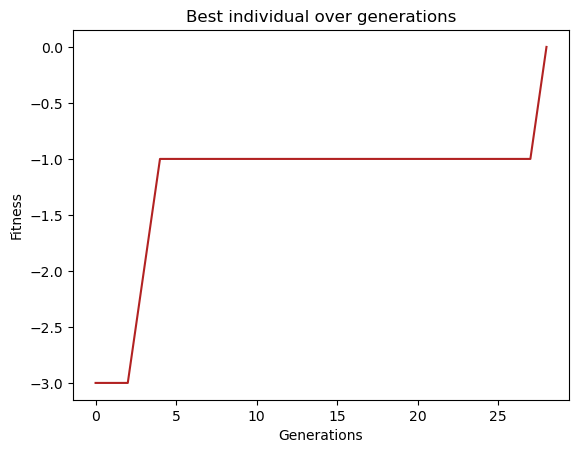

In [54]:
# Let us plot the fitness of the best individual in time
plt.plot(best_list,color = "firebrick")
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Best individual over generations')
plt.show()

### Discussion Results

In this straightforward example, we see that the convergence times vary with the grid size (n_bits). Because of chance, the convergence for small grid sizes occurs instantly occasionally even in the first generation. However, the technique converges in a fair period of time and generalizes well to larger grid sizes as well.

## Sudoku

**Objective**: fill a 9x9 grid with digits so that each column, each row and each of the nine 3x3 subgrids that compose the grid contains all of the digits from 1 to 9.

First, I will utilize a database to randomly select a Sudoku puzzle. To find the solution, I will then apply a backtracking algorithm, which I will explain in the following section.

Secondly, I will use a genetic algorithm to solve the sudoku using as a fitness the closeness to the correct solution. 

In the appendix, I will also show my try to solve directly the sudoku with a genetic algorithm without employing the backtracking algotihm .

Here I present my techniques in order to solve this problem:
1. **Population**: I will use the clever representation of the N-Queens Problem but in matrix format so every individual will be a 9X9 matrix, where the row $i \in \{1, \cdots,9\}$ tells us the vertical positions of number $i$ in the sudoku grid;
2. **Fitness funtion**: to assess the quality of an individual I count the number different from the correct solution of the backpropagating algorithm;
3. **Selection procedure**: I will use a tournament selection so a number of inidividuals $k$ will be chosen randomly and the one with the highest fitness will be selected to be a parent. 
4. **Crossover**: I will use the same crossover as the N-Queens problem but I will repeat it for every row, the only difference is that if I find an individual with a totally correct row it passes the whole row without any change.
5. **Mutation**: I employ two kind of mutations, Scramble mutation and Swap Mutation. The first take a random set of numbers in an individual and it shuffle it, while the second take randomly two numbers and invert them.
6. **Selection procedure II**: since I seek for a very fit individual instead of a fit population,in order to increase convergence times I perform crossover and then both type of mutations for a total of 2 parents and 4 children and I take the two most fitnessed ones.
5. Continue until **Fitness = 0** 

### Sudoku Database import 

In [55]:
# Function to visualize the Sudoku grid
def visualize_sudoku(sudoku):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(np.ones_like(sudoku), cmap='Greys', vmin=0, vmax=2)

    for i in range(9):
        for j in range(9):
            if sudoku[i, j] != 0:
                ax.text(j, i, sudoku[i, j], va='center', ha='center', fontsize=20)
    
    # Major grid lines
    for i in range(1, 9):
        linewidth = 3 if i % 3 == 0 else 1
        ax.axhline(i - 0.5, color='black', linewidth=linewidth)
        ax.axvline(i - 0.5, color='black', linewidth=linewidth)

    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

In [56]:
file_path = 'Sudoku_database.json'
with open(file_path, 'r') as file:
    json_data = json.load(file)

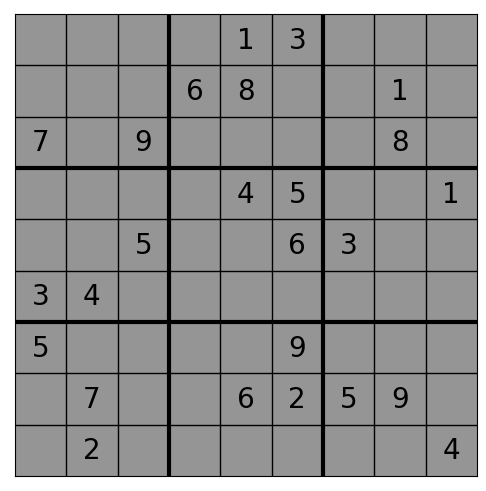

In [57]:
sample_sudoku = np.array([int(char) for char in json_data['Hard'][0]]).reshape(9, 9)
visualize_sudoku(sample_sudoku)


### Backtracking algorithm

I took the code from: https://github.com/Zelkann/Sudoku-Solver-with-Backtracking-Algorithm/tree/main

The algorithm finds an empty cell and attempts to place each value from 1 to 9 in that cell, checking the validity of each placement using row, column, and subgrid constraints. It recursively solves the rest of the board, backtracking by undoing invalid moves until all solutions are found.

In [58]:
# Check the empty cells avaiable in the sudoku
def find_empty_cell(board):
    for row in range(9):
        for col in range(9):
            if board[row][col] == 0:
                return row, col
    return None

# check is placing a value in (row,col) is a feasible solution for sudoku
def is_valid(board, row, col, value):
    # Check for row and column constraint
    for i in range(9):
        if value in [board[row][i], board[i][col]]:
            return False

    # Check for box constraint
    box_row_index = row // 3
    box_col_index = col // 3
    for r in range(3):
        for c in range(3):
            if board[box_row_index * 3 + r][box_col_index * 3 + c] == value:
                return False

    return True
def get_solutions_by_backtracking(board, solutions):
    

    # locating the empty cell
    empty_cell = find_empty_cell(board)

    # base case: solution is found
    if empty_cell is None:
        solutions.append([[cell for cell in row] for row in board])
        return solutions

    # fill in the empty cell with a value and perform backtracking algorithm thereafter
    row, col = empty_cell
    for value in range(1, 10):
        if is_valid(board, row, col, value):
            board[row][col] = value
            get_solutions_by_backtracking(board, solutions)
            board[row][col] = 0
    return solutions

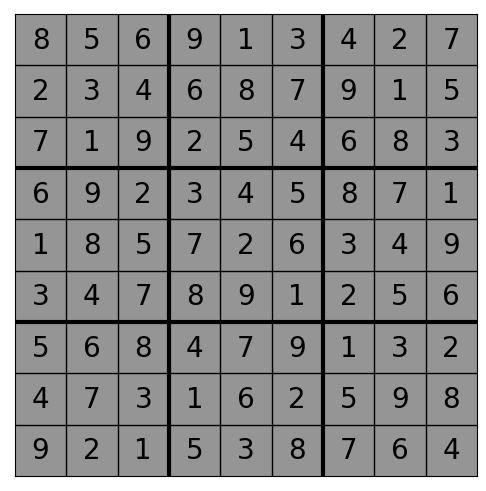

In [59]:
solution = get_solutions_by_backtracking(sample_sudoku,[])
solution = solution[0]
visualize_sudoku(np.array(solution))

Now let us put the solution sudoku in coordinates as we did with the N-Queens problem

In [60]:
# Save coordinates of numbers
solution_position = {i:[] for i in range(1,10)}
for vert_pos,j in enumerate(solution):
  for horiz_pos in range(len(j)):
    solution_position[j[horiz_pos]].append((vert_pos,horiz_pos))

# Put in N-Queens problem coordinates
solution_array = [[0]*9 for _ in range(9)]
for key in range(9):
  for i,j in solution_position[key+1]:
    solution_array[key][j] = i
solution_array

[[4, 2, 8, 7, 0, 5, 6, 1, 3],
 [1, 8, 3, 2, 4, 7, 5, 0, 6],
 [5, 1, 7, 3, 8, 0, 4, 6, 2],
 [7, 5, 1, 6, 3, 2, 0, 4, 8],
 [6, 0, 4, 8, 2, 3, 7, 5, 1],
 [3, 6, 0, 1, 7, 4, 2, 8, 5],
 [2, 7, 5, 4, 6, 1, 8, 3, 0],
 [0, 4, 6, 5, 1, 8, 3, 2, 7],
 [8, 3, 2, 0, 5, 6, 1, 7, 4]]

### Fitness SU
The fitness is the number ot different values with respect to the solution

In [61]:
# Check error in a fixed row 
def fitness_row(X,k):
  local_err = 0
  for i,j in zip(solution_array[k],X[k]):
    if i != j:
      local_err += 1
  return local_err

def fitness_SU(X):
  err = 0
  for k in range(len(X)):
    counter = fitness_row(X,k)
    err += counter
  # Always keep the negative value
  return -err

### Crossover SU
We repeat the cycle crossover for each row, but if we have correct rows we spread them with a full crossover

In [62]:
def crossoverSU(p1,p2,r):
  c1,c2 = p1.copy(),p2.copy()
  # Crossover of single rows
  for i in range(len(p1)):
    a,b = c1[i].copy(),c2[i].copy()
    # I spread the correct rows to all the children (I seek a fit individual not a fit population)
    if fitness_row(c1,i) == 0:
      c2[i] = c1[i]
      continue
    elif fitness_row(c2,i) == 0:
      c1[i] = c2[i]
      continue
    # If not do cycle crossover
    else:
      c1[i],c2[i] = crossoverQP(a,b,r)
  return c1,c2

### Mutation SU 1

In [63]:
def mutationSU1(c,m,nbits):
  # Scramble mutation for each row
  mut_c = c.copy()
  for i in range(len(c)):
    if fitness_row(mut_c,i) == 0:
      continue
    else:
      mut_c[i] = mutationQP1(mut_c[i],m,nbits)
  return mut_c

### Mutation SU 2

In [64]:
def mutationSU2(c,m,nbits):
  # Swap mutation for each row
  mut_c = c.copy()
  for i in range(len(c)):
    if fitness_row(mut_c,i) == 0:
      continue
    else:
      mut_c[i] = mutationQP2(mut_c[i],m,nbits)
  return mut_c

### Selection SU
We employ the same selection as N-queens problem

In [65]:
def tournament_selection(pop,scores,k = 2):
    selection_ix = np.random.randint(0,len(pop))
    for i in np.random.randint(0,len(pop),k-1):
        if scores[i] > scores[selection_ix]:
            selection_ix = i
    return pop[selection_ix]

### Genetic Algorithm SU

In [66]:
def genetic_alg_SU(objective, n_individuals, n_generation, n_bits, r,m,k= 2):

    # Initialize randomly the population
    pop = [[random.sample(range(0,n_bits),n_bits) for i in range(n_bits)] for _ in range(n_individuals)]

    # keep track of the best score
    best, best_score = pop[0], objective(pop[0])
    best_list = []

    for gen in range(n_generation):

        # compute the scores
        scores = [objective(i) for i in pop]
        # always keep track of best score
        for i in range(n_individuals):
            if scores[i] > best_score:
                best_score = scores[i]
                best = pop[i]
                print(f"New performing individual {best} of fitness {best_score} in generation {gen}")
        best_list.append(best_score)
        if float(best_score) == 0.0:
          return best, best_score, best_list
        
        # After 10 generations I try to converge to the optimal solution by increasing parameter of tournament selection
        # decrease crossover parameter (so decrease exploration) increase mutation parameter (increase exploitation)
        if gen % 10 == 0 and gen != 0:
          k += 1
          r -= 0.05
          m += 0.05
        # Let us select parents
        parents = [tournament_selection(pop,scores,k) for _ in range(n_individuals)]
        # Children
        children = []
        # Reproduction
        for j in range(0,n_individuals,2):
            # Recombination
            p1,p2 = parents[j], parents[j+1]
            c1,c2 = crossoverSU(p1,p2,r)
            # Mutation alleles and rows we randomize the type of mutation for a more heterogeneous population
            a = np.random.randint(0,2)
            if a == 0:
                c1 = mutationSU1(c1,m,n_bits)
                c2 = mutationSU1(c2,m,n_bits)
            else:
                c1 = mutationSU2(c1,m,n_bits)
                c1 = mutationSU2(c2,m,n_bits)
            # Pick the two with highest fitness
            people = [p1,p2,c1,c2]
            points = [objective(p1),objective(p2),objective(c1),objective(c2)]
            sorted_indices = np.argsort(points)[-2:][::-1]
            top_two = [people[i] for i in sorted_indices]
            children.append(top_two[0])
            children.append(top_two[1])
        pop = children[:]

    # Let us recompute final scores
    for i in range(n_individuals):
        if scores[i] > best_score:
            best_score = scores[i]
            best = pop[i]
            print(f"New performing individual {best} of fitness {best_score} in generation {n_generation}")
    best_list.append(best_score)

    return (best, best_score, best_list)

In [67]:
n_individuals = 1000
n_generation = 100
n_bits = 9
r = 0.9
m = 1/81

best, best_score ,best_list= genetic_alg_SU(fitness_SU, n_individuals, n_generation, n_bits, r,m,k=2)

New performing individual [[8, 2, 5, 1, 3, 7, 6, 0, 4], [4, 6, 2, 0, 1, 8, 5, 3, 7], [6, 1, 7, 0, 2, 8, 4, 3, 5], [5, 4, 0, 6, 8, 7, 3, 1, 2], [1, 4, 3, 8, 5, 6, 7, 0, 2], [3, 2, 0, 8, 4, 6, 7, 1, 5], [8, 4, 1, 6, 2, 3, 7, 5, 0], [5, 2, 7, 0, 4, 1, 8, 3, 6], [8, 0, 4, 2, 3, 6, 7, 5, 1]] of fitness -66 in generation 0
New performing individual [[0, 7, 3, 8, 4, 5, 1, 6, 2], [5, 3, 2, 1, 4, 7, 0, 8, 6], [0, 6, 5, 7, 3, 1, 4, 8, 2], [1, 5, 4, 0, 3, 6, 7, 8, 2], [4, 8, 0, 2, 5, 1, 3, 6, 7], [7, 6, 3, 5, 1, 0, 4, 8, 2], [4, 6, 3, 1, 2, 0, 7, 8, 5], [6, 4, 8, 5, 0, 2, 1, 3, 7], [1, 3, 2, 4, 5, 7, 0, 8, 6]] of fitness -65 in generation 0
New performing individual [[1, 3, 5, 8, 2, 4, 7, 6, 0], [6, 5, 1, 3, 4, 7, 2, 0, 8], [5, 2, 7, 4, 8, 0, 3, 1, 6], [6, 1, 0, 3, 5, 4, 7, 8, 2], [0, 1, 4, 6, 3, 2, 7, 5, 8], [3, 4, 6, 5, 1, 2, 0, 8, 7], [6, 8, 2, 4, 0, 1, 3, 7, 5], [4, 6, 5, 7, 8, 0, 3, 2, 1], [8, 1, 7, 4, 5, 3, 0, 2, 6]] of fitness -63 in generation 0
New performing individual [[4, 5, 6, 1, 8, 

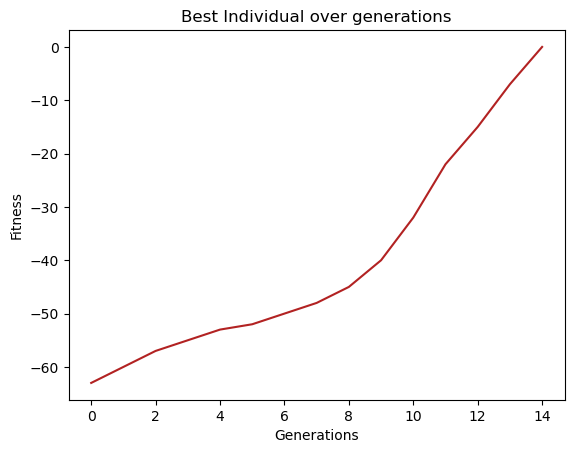

In [68]:
# Let us plot the fitness of the best individual in time
plt.plot(best_list,color = "firebrick")
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Best Individual over generations')
plt.show()

### Discussion and conclsuion

As we can see from the results, we may use a relatively small number of individuals only 1000 to converge to the sudoku solution in just 14–20 generations. But in the end, we had to rely on the backtraking algorithm and develop a genetic programming scheme around it, even after multiple attempts. Consequently, the backpropagation method discovers the solution considerably more quickly than the evolutionary technique since it is faster and uses less randomness in its construction. However, although the algorithm's implementation was entertaining and difficult, we are unable to claim that it resulted in a faster rate of convergence. I'll attempt to solve the sudoku problem straight in the appendix without using the backtracking phase.

# Appendix

## Direct Sudoku Solving

**Objective**: fill a 9x9 grid with digits so that each column, each row and each of the nine 3x3 subgrids that compose the gridcontains all of the digits from 1 to 9.

First, I will utilize a database to randomly select a Sudoku puzzle. To find the solution, I will then apply a genetic algorithm using the same representation used before and perform mutations and crossover both between values in singular rows both between the rows themselves.

Here I present my techniques in order to solve this problem:
1. **Population**: I will use the clever representation of the N-Queens Problem but in matrix format so every individual will be a 9X9 matrix, where the row $i \in \{1, \cdots,9\}$ tells us the vertical positions of number $i$ in the sudoku grid;
2. **Fitness funtion**: in order to evaluate an individual's quality, I start by counting the number of times that the same position is not repeated. For instance, if individual[5][7] = 2 and individual[4][7] = 2, this indicates that the solution consists of placing the number in the same place, which I count as an error. Secondly, it has to respect  the restriction imposed by the sudoku puzzle itself.
3. **Selection procedure**: I will use a tournament selection so a number of inidividuals $k$ will be chosen randomly and the one with the highest fitness will be selected to be a parent. 
4. **Crossover**: The cycle crossover I'll use is the same as the one used in the N-Queens problem, but I'll repeat it for each row separately and perform crossover between the row positions as well. The latter one will be a standard crossover.
5. **Mutation**: I employ two kind of mutations, Scramble mutation and Swap Mutation. The first take a random set of numbers in an individual and it shuffle it, while the second take randomly two numbers and invert them. As the crossover they would be employed both for the values inside the rows and the positions.
6. **Selection procedure II**: since I seek for a very fit individual instead of a fit population,in order to increase convergence times I perform crossover and then both type of mutations for a total of 2 parents and 4 children and I take the two most fitnessed ones.
5. Continue until **Fitness = 0** 

### Sudoku Database import 

In [69]:
# Function to visualize the Sudoku grid
def visualize_sudoku(sudoku):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(np.ones_like(sudoku), cmap='Greys', vmin=0, vmax=2)

    for i in range(9):
        for j in range(9):
            if sudoku[i, j] != 0:
                ax.text(j, i, sudoku[i, j], va='center', ha='center', fontsize=20)
    
    # Major grid lines
    for i in range(1, 9):
        linewidth = 3 if i % 3 == 0 else 1
        ax.axhline(i - 0.5, color='black', linewidth=linewidth)
        ax.axvline(i - 0.5, color='black', linewidth=linewidth)

    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

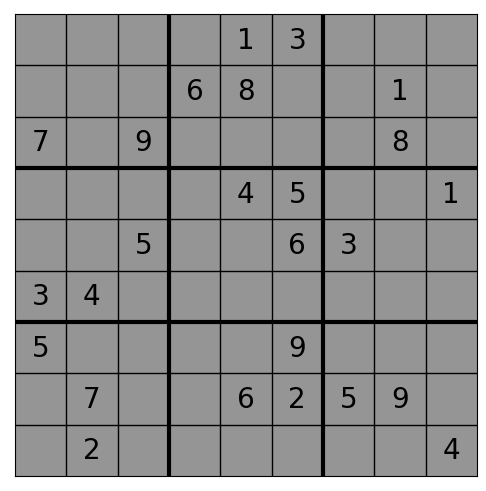

In [70]:
file_path = 'Sudoku_database.json'
with open(file_path, 'r') as file:
    json_data = json.load(file)
sample_sudoku = np.array([int(char) for char in json_data['Hard'][0]]).reshape(9, 9)
visualize_sudoku(sample_sudoku)

### Fitness SU1

In [71]:
# Function to check whethere there are two numbers in the same position
def same_no_col(x,err = 0):
  a = np.array(x)
  for j in a.T:
    l1,l2 = len(j),len(set(j))
    err -= l1-l2
  return err

# Constraints of sudoku
dict_position = {i:[] for i in range(1,10)}
for vert_pos,j in enumerate(sample_sudoku):
  for horiz_pos in range(len(j)):
    if j[horiz_pos] != 0:
      dict_position[j[horiz_pos]].append((vert_pos,horiz_pos))

In [72]:
def fitness_SU1(X):
  # Fitness value
  fit = 0
  # Sudoku Constraint
  for idx,row in enumerate(X,start = 1):
    val = dict_position[idx]
    for vert_pos,horiz_pos in val:
      if row[horiz_pos] != vert_pos:
        fit -= 1
  # Penalize also the same position
  fit = same_no_col(X,fit)
  return fit

### Crossover SU1

In [73]:
def crossoverSU1(p1,p2,r,l):
  c1,c2 = p1.copy(),p2.copy()
  # Cycle Crossover with values inside the list
  for i in range(len(p1)):
    a,b = c1[i].copy(),c2[i].copy()
    c1[i],c2[i] = crossoverQP(a,b,r)

  # Standard Crossover of whole lists
  if np.random.random() < l:
    cross_point = np.random.randint(0,9)
    a1,a2 = c1.copy(),c2.copy()
    c1 = a1[:cross_point] + a2[cross_point:9]
    c2 = a2[:cross_point] + a1[cross_point:9]

  return c1,c2

### Mutation SU11

In [74]:
def mutationSU11(c,m,b,nbits):
  # Mutation of values in the lists
  mut_c = c.copy()
  for i in range(len(c)):
    mut_c[i] = mutationQP1(mut_c[i],m,nbits)
  # Scramble Mutation of lists position
  if np.random.randn() < b:
    a = np.random.randint(0,8)
    b = np.random.randint(a+1,9)
    shuffle_list = mut_c[a:b]
    random.shuffle(shuffle_list)
    mut_c[a:b] = shuffle_list
  return mut_c

### Mutation SU21

In [75]:
def mutationSU21(c,m,b,nbits):
  # Mutation of values in the lists
  mut_c = c.copy()
  for i in range(len(c)):
    mut_c[i] = mutationQP2(mut_c[i],m,nbits)
  # Swap Mutation of whole lists
  if np.random.randn() < b:
    a,b = random.sample(range(0,9),2)
    val1,val2 = mut_c[a],mut_c[b]
    mut_c[a] = val2
    mut_c[b] = val1
  return mut_c

### Selection SU1

In [76]:
def tournament_selection(pop,scores,k = 2):
    selection_ix = np.random.randint(0,len(pop))
    for i in np.random.randint(0,len(pop),k-1):
        if scores[i] > scores[selection_ix]:
            selection_ix = i
    return pop[selection_ix]

### Genetic Algorithm

In [77]:
def genetic_algSU1(objective, n_individuals, n_generation, n_bits, r,l,m,b,k= 2):

    # Initialize randomly the population
    pop = [[random.sample(range(0,n_bits),n_bits) for i in range(n_bits)] for _ in range(n_individuals)]

    # keep track of the best score
    best, best_score = pop[0], objective(pop[0])
    best_list = []

    for gen in range(n_generation):

        # compute the scores
        scores = [objective(i) for i in pop]
        # always keep track of best score
        for i in range(n_individuals):
            if scores[i] > best_score:
                best_score = scores[i]
                best = pop[i]
                print(f"New performing individual {best} of fitness {best_score} in generation {gen}")
        best_list.append(best_score)
        if float(best_score) == 0.0:
          return best, best_score, best_list
        
        # After 10 generations I try to converge to the optimal solution by increasing parameter of tournament selection
        # decrease crossover parameter (so decrease exploration) increase mutation parameter (increase exploitation)
        if gen % 10 == 0 and gen != 0:
          k += 1
          r -= 0.5
          l -= 0.5
          m += 0.5
          b += 0.5
        # Let us select parents
        parents = [tournament_selection(pop,scores,k) for _ in range(n_individuals)]
        # Children
        children = []
        # Reproduction
        for j in range(0,n_individuals,2):
            # Recombination
            p1,p2 = parents[j], parents[j+1]
            c1,c2 = crossoverSU(p1,p2,r)
            # Mutation alleles and rows
            a = np.random.randint(0,2)
            if a == 0:
                c1 = mutationSU11(c1,m,b,n_bits)
                c2 = mutationSU11(c2,m,b,n_bits)
            else:
                c1 = mutationSU21(c1,m,b,n_bits)
                c1 = mutationSU21(c2,m,b,n_bits)
            # Pick the two with highest fitness
            people = [p1,p2,c1,c2]
            points = [objective(p1),objective(p2),objective(c1),objective(c2)]
            sorted_indices = np.argsort(points)[-2:][::-1]
            top_two = [people[i] for i in sorted_indices]
            children.append(top_two[0])
            children.append(top_two[1])
            children.append(c1)
            children.append(c2)
        pop = children[:]

    # Let us recompute final scores
    for i in range(n_individuals):
        if scores[i] > best_score:
            best_score = scores[i]
            best = pop[i]
            print(f"New performing individual {best} of fitness {best_score} in generation {n_generation}")
    best_list.append(best_score)

    return (best, best_score, best_list)

In [78]:
n_individuals = 10000
n_generation = 200
n_bits = 9
r = 0.9
l = 0.8
m = 1.0/ float(n_bits*n_bits)
b = m
best, best_score,best_list = genetic_algSU1(fitness_SU1, n_individuals, n_generation, n_bits, r,l,m,b)

New performing individual [[2, 3, 0, 4, 8, 1, 7, 5, 6], [0, 3, 5, 2, 7, 4, 6, 8, 1], [3, 2, 7, 4, 0, 6, 8, 1, 5], [4, 8, 1, 3, 0, 5, 7, 6, 2], [1, 7, 2, 4, 3, 6, 0, 5, 8], [8, 4, 0, 1, 7, 3, 6, 5, 2], [7, 5, 2, 6, 8, 3, 0, 4, 1], [7, 5, 4, 0, 1, 8, 6, 2, 3], [4, 6, 1, 3, 0, 5, 2, 7, 8]] of fitness -46 in generation 0
New performing individual [[3, 1, 8, 6, 0, 7, 4, 2, 5], [0, 8, 5, 3, 1, 7, 6, 2, 4], [0, 4, 6, 2, 5, 7, 8, 1, 3], [1, 5, 7, 3, 4, 8, 2, 0, 6], [8, 2, 4, 0, 5, 7, 6, 3, 1], [4, 5, 3, 6, 2, 8, 0, 1, 7], [7, 1, 0, 6, 2, 4, 3, 8, 5], [7, 0, 3, 2, 1, 6, 8, 5, 4], [5, 8, 2, 3, 6, 1, 7, 0, 4]] of fitness -44 in generation 0
New performing individual [[2, 5, 7, 0, 4, 3, 6, 1, 8], [4, 6, 0, 3, 8, 7, 1, 5, 2], [5, 0, 8, 1, 7, 6, 4, 2, 3], [5, 8, 2, 4, 3, 0, 7, 6, 1], [1, 7, 3, 4, 2, 0, 8, 6, 5], [2, 6, 3, 7, 4, 0, 5, 8, 1], [2, 4, 1, 5, 8, 3, 6, 0, 7], [8, 1, 5, 3, 6, 2, 7, 0, 4], [0, 2, 3, 4, 7, 5, 1, 8, 6]] of fitness -41 in generation 0
New performing individual [[8, 7, 6, 3, 2, 

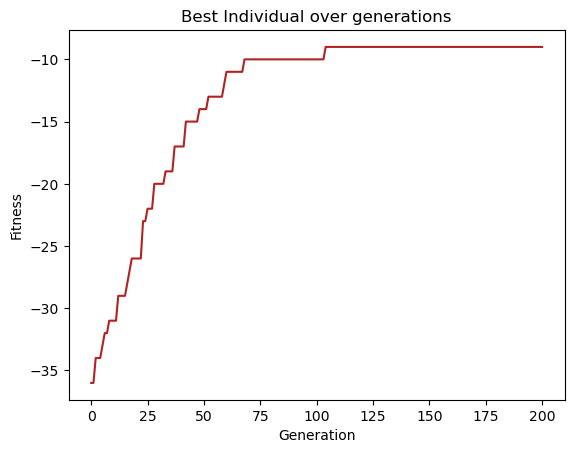

In [80]:
# Let us plot the fitness of the best individual in time
plt.plot(best_list,color = "firebrick")
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Best Individual over generations')
plt.show()

### Discussion
The genetic algorithm takes a long time to run and fails to converge despite having a high number of individuals and generations. This effect can likely be attributed to the problem's rising randomness because there are $9^{81}$ potential combinations to find a unique solution. To truly converge, more people, more generations, and more computing time will probably be needed.

# Bibliography

[1] https://nidragedd.github.io/sudoku-genetics/

[2] https://github.com/Zelkann/Sudoku-Solver-with-Backtracking-Algorithm/tree/main

[3] A.E. Eiben, J.E. Smith. Introduction to Evolutionary Computing,Springer Berlin, Heidelberg.2015